In [1]:
# to use GPU 
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

11.7
True


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [2]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [3]:
def evaluate_accuracy(net, data_iter, devices=None):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  # Set the model to evaluation mode
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if devices is not None:
                # Use the first device in the list for this example
                X, y = X.to(devices[0]), y.to(devices[0])
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    net.train()  # Set the model back to training mode
    return acc_sum / n

## BiRNN

In [4]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return outs


In [5]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

TokenEmbedding GPU

In [7]:
import os

In [8]:
# class that use GPU
#@save
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec).cuda() # move tensor to the GPU

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [9]:
# GloVe embeddings of dimension 50, 100, and 300
# 'glove.6b.50d' , 'glove.6b.100d' , 'glove.42b.300d'
# fastText embeddings : 'wiki.en'

GLoVE

In [10]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d') # no move to GPU because of a problem with WSL
embeds_glove = glove_embedding[vocab.idx_to_token]
embeds_glove.shape

torch.Size([49346, 100])

In [11]:
net_glove = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [12]:
net_glove.apply(init_weights);

In [13]:
net_glove.embedding.weight.data.copy_(embeds_glove)
net_glove.embedding.weight.requires_grad = False

loss 0.293, train acc 0.881, test acc 0.853
193.1 examples/sec on [device(type='cuda', index=0)]


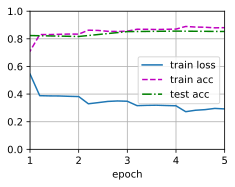

In [14]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_glove.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net_glove, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [15]:
predict_sentiment(net_glove, vocab, 'this movie is so great')

'positive'

In [16]:
predict_sentiment(net_glove, vocab, 'this movie is so bad')

'negative'

FastText

In [6]:
#@save
class LocalTokenEmbedding:
    """Local Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = embedding_name
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(data_dir, 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

after the installation of fastText : https://fasttext.cc/docs/en/support.html#building-fasttext-python-module

download cc.en.300.bin.gz : https://fasttext.cc/docs/en/crawl-vectors.html#download-directly-with-command-line-or-from-python:~:text=Download%20directly%20with%20command%20line%20or%20from%20python

adapt the dimension to 100 : https://fasttext.cc/docs/en/crawl-vectors.html#download-directly-with-command-line-or-from-python:~:text=10%0AQuery%20word%3F-,Adapt%20the%20dimension,-The%20pre%2Dtrained

and obtain VEC file from the BIN file with this code: https://stackoverflow.com/questions/58337469/how-to-save-fasttext-model-in-vec-format/58342618#58342618:~:text=15-,To%20obtain%20VEC%20file,-%2C%20containing%20merely%20all

In [7]:
fast_embedding = LocalTokenEmbedding('cc.en.100.vec') # use local path of the file instead of URL
embeds_fast = fast_embedding[vocab.idx_to_token]
embeds_fast.shape

torch.Size([49346, 100])

In [8]:
net_fast = BiRNN(len(vocab), embed_size, num_hiddens, num_layers) # change embed_size to 300 to correspond with size of wiki-news-300d-1M.vec

In [9]:
net_fast.apply(init_weights);

In [10]:
net_fast.embedding.weight.data.copy_(embeds_fast)
net_fast.embedding.weight.requires_grad = False

loss 0.333, train acc 0.856, test acc 0.846
164.4 examples/sec on [device(type='cuda', index=0)]


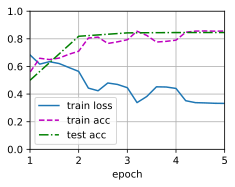

In [11]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_fast.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net_fast, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [12]:
predict_sentiment(net_fast, vocab, 'this movie is so great')

'positive'

In [13]:
predict_sentiment(net_fast, vocab, 'this movie is so bad')

'negative'

In [25]:
# Evaluate and compare performance on the test set
accuracy_glove = evaluate_accuracy(net_glove, test_iter, devices)
accuracy_fast = evaluate_accuracy(net_fast, test_iter, devices)

print(f'Accuracy with GloVe: {accuracy_glove:.4f}')
print(f'Accuracy with FastText: {accuracy_fast:.4f}')


Accuracy with GloVe: 0.8531
Accuracy with FastText: 0.8594


## GRU

In [26]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(GRU, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.GRU(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs


GLoVE

In [27]:
net_glove = GRU(len(vocab), embed_size, num_hiddens, num_layers)

In [28]:
net_glove.apply(init_weights);
net_glove.embedding.weight.data.copy_(embeds_glove)
net_glove.embedding.weight.requires_grad = False

loss 0.265, train acc 0.891, test acc 0.860
260.0 examples/sec on [device(type='cuda', index=0)]


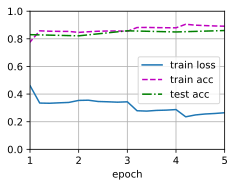

In [29]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_glove.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net_glove, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [30]:
predict_sentiment(net_glove, vocab, 'this movie is so great')

'positive'

In [31]:
predict_sentiment(net_glove, vocab, 'this movie is so bad')

'negative'

FastText

In [34]:
net_fast = GRU(len(vocab), embed_size, num_hiddens, num_layers)

In [35]:
net_fast.apply(init_weights);
net_fast.embedding.weight.data.copy_(embeds_fast)
net_fast.embedding.weight.requires_grad = False

loss 0.258, train acc 0.895, test acc 0.862
218.4 examples/sec on [device(type='cuda', index=0)]


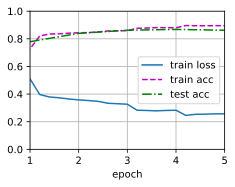

In [36]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net_fast.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net_fast, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [37]:
predict_sentiment(net_fast, vocab, 'this movie is so great')

'positive'

In [38]:
predict_sentiment(net_fast, vocab, "this movie is so bad")

'negative'

In [39]:
# Assuming net_glove and net_fast are your neural network models,
# test_iter is your test data iterator, and devices is a list of devices.
accuracy_glove = evaluate_accuracy(net_glove, test_iter, devices)
accuracy_fast = evaluate_accuracy(net_fast, test_iter, devices)

print(f'Accuracy with GloVe: {accuracy_glove:.4f}')
print(f'Accuracy with FastText: {accuracy_fast:.4f}')


Accuracy with GloVe: 0.8600
Accuracy with FastText: 0.8622


In [ ]:
# from fasttext import load_model

# original BIN model loading
# f = load_model('/home/lionel/INFO2049/Sentiment_analysis/fastText/fastText/cc.en.100.bin')
# lines=[]

# get all words from model
# words = f.get_words()

# with open('cc.en.100.vec','w') as file_out:
    
    # the first line must contain number of total words and vector dimension
#     file_out.write(str(len(words)) + " " + str(f.get_dimension()) + "\n")

    # line by line, you append vectors to VEC file
#     for w in words:
#         v = f.get_word_vector(w)
#         vstr = ""
#         for vi in v:
#            vstr += " " + str(vi)
#         try:
#             file_out.write(w + vstr+'\n')
#         except:
#             pass